In [1]:
# Download the file
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# Extract the file
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2024-06-25 22:00:14--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  1.22MB/s    in 47s     

2024-06-25 22:01:03 (1.29 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


{0: 'Arnold_Schwarzenegger', 1: 'George_W_Bush', 2: 'Junichiro_Koizumi', 3: 'Tony_Blair', 4: 'Vladimir_Putin'}
Epoch 1/10, Loss: 1.6583006630220944
Epoch 2/10, Loss: 1.5909329245800545
Epoch 3/10, Loss: 1.5163553528866525
Epoch 4/10, Loss: 1.4876599623562348
Epoch 5/10, Loss: 1.406043692304782
Epoch 6/10, Loss: 1.3851344960653753
Epoch 7/10, Loss: 1.3228481930046914
Epoch 8/10, Loss: 1.2891526487779963
Epoch 9/10, Loss: 1.3026687585124093
Epoch 10/10, Loss: 1.2878579054271337
0.65088 : George_W_Bush
0.20728 : Tony_Blair
0.07709 : Vladimir_Putin
0.03418 : Junichiro_Koizumi
0.03067 : Arnold_Schwarzenegger
Accuracy on test set: 61.21%


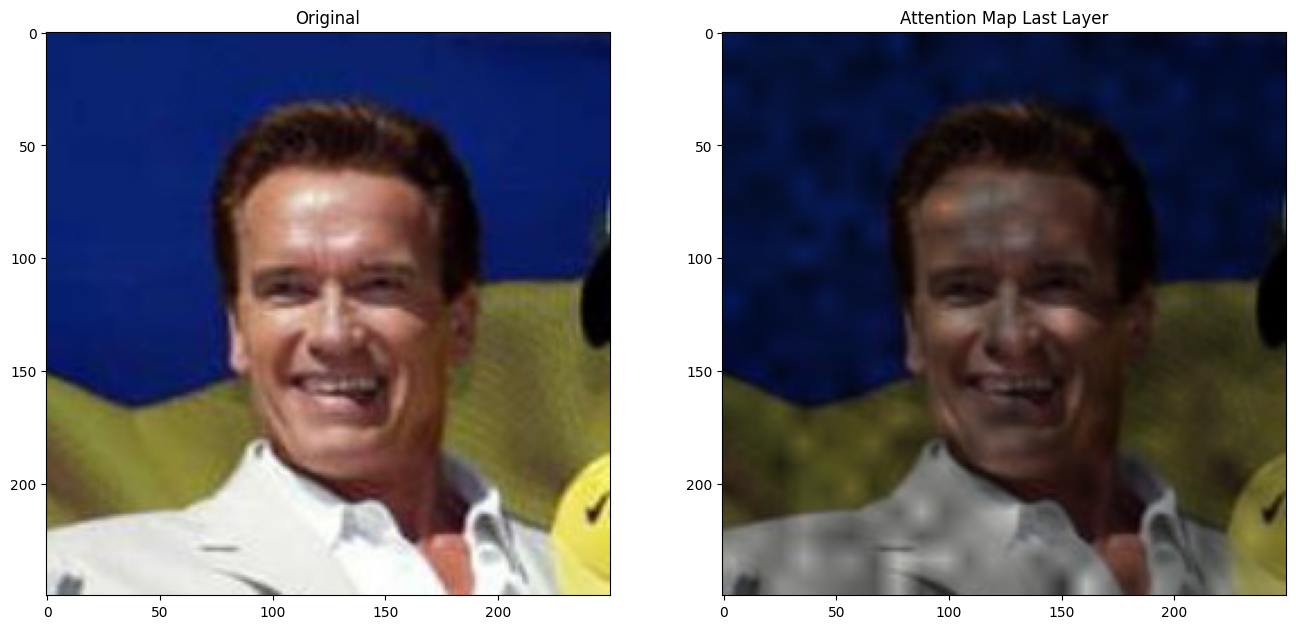

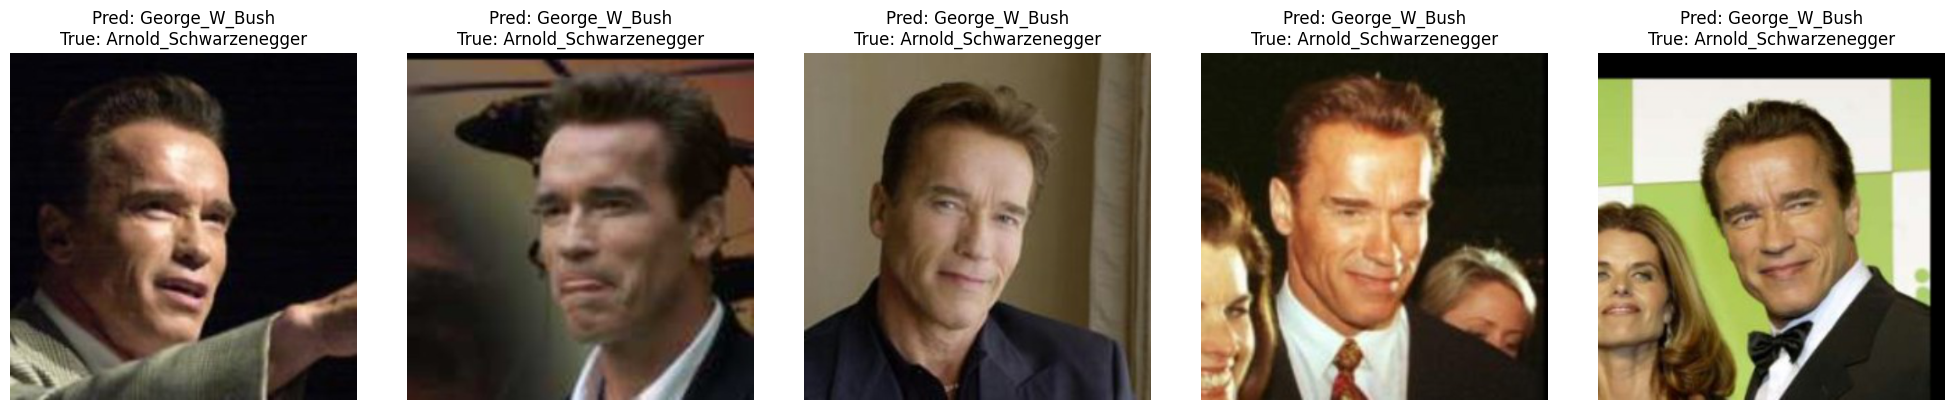

0.65088 : George_W_Bush
0.20728 : Tony_Blair
0.07709 : Vladimir_Putin
0.03418 : Junichiro_Koizumi
0.03067 : Arnold_Schwarzenegger
Predictions with nose features:
0.65088 : George_W_Bush
0.20728 : Tony_Blair
0.07709 : Vladimir_Putin
0.03418 : Junichiro_Koizumi
0.03067 : Arnold_Schwarzenegger

Predictions without nose features:
0.24536 : Junichiro_Koizumi
0.23157 : Vladimir_Putin
0.22192 : Tony_Blair
0.15918 : Arnold_Schwarzenegger
0.14197 : George_W_Bush


In [1]:
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torch.optim import Optimizer
import math
import dlib

from VisionTransformerPytorch.vision_transformer_pytorch import VisionTransformer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NoseEmbeddingMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NoseEmbeddingMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ViTWithNose(nn.Module):
    def __init__(self, vit_model, nose_embedding_dim, img_size=384, patch_size=16):
        super(ViTWithNose, self).__init__()
        self.vit = vit_model
        self.nose_mlp = NoseEmbeddingMLP(nose_embedding_dim, img_size * img_size * 3)
        self.img_size = img_size
        self.patch_size = patch_size

    def forward(self, img, nose_embedding):
        B, C, H, W = img.shape
        nose_proj = self.nose_mlp(nose_embedding)
        nose_proj = nose_proj.view(B, C, H, W)
        combined_input = img + nose_proj
        return self.vit(combined_input)

# Load the pre-trained ViT model
vit_model = VisionTransformer.from_name('ViT-B_16', num_classes=5)
model = ViTWithNose(vit_model, nose_embedding_dim=18).to(device)  # 18 = 9 points * 2 coordinates

def extract_nose_features(image_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    nose_points = []
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(27, 36):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            nose_points.append((x, y))

    nose_points = np.array(nose_points, np.float32)
    return nose_points.flatten()


def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)



class CelebDatasetWithNose(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    def __len__(self):
        return len(self.data)
    
    def extract_nose_features(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return np.zeros(18, dtype=np.float32)  # Return zeros if image can't be read
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray)
        
        if len(faces) == 0:
            return np.zeros(18, dtype=np.float32)  # Return zeros if no face detected
        
        face = faces[0]  # Use the first detected face
        landmarks = self.predictor(gray, face)
        
        nose_points = []
        for n in range(27, 36):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            nose_points.append((x, y))
        
        nose_points = np.array(nose_points, np.float32)
        return nose_points.flatten()
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        img_path = self.data.imgs[idx][0]
        
        try:
            nose_features = self.extract_nose_features(img_path)
        except Exception as e:
            print(f"Error extracting nose features from {img_path}: {str(e)}")
            nose_features = np.zeros(18, dtype=np.float32)  # Return zeros in case of any error
        
        return img, torch.tensor(nose_features, dtype=torch.float32), label
    
    @property
    def classes(self):
        return self.data.classes
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load dataset
data_dir = 'data/train'
dataset = CelebDatasetWithNose(data_dir, transform)

# Create target_to_class mapping
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Training loop
import torch.cuda.amp as amp
from torch.optim import Adam

# Set up mixed precision training
scaler = amp.GradScaler(init_scale=2**10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for batch_idx, (data, nose_features, target) in enumerate(train_loader):
        data, nose_features, target = data.to(device), nose_features.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Use autocast for mixed precision training
        with amp.autocast():
            logits, _ = model(data,nose_features)     
            loss = criterion(logits, target)
        
        # Scale the loss and call backward
        scaler.scale(loss).backward()
        
        # Unscale gradients and clip as needed
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Step the optimizer and update the scale
        scaler.step(optimizer)
        scaler.update()
        
        run_loss += loss.item()
    
    run_loss /= len(train_loader)
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {run_loss}")

# Function to predict class for a single image and get attention maps
def predict_and_get_attention(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    nose_features = torch.tensor(extract_nose_features(image_path)).unsqueeze(0).to(device)
    
    transformed_image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        logits, att_mat = model(transformed_image, nose_features)
        probs = torch.nn.Softmax(dim=-1)(logits)
        top5 = torch.argsort(probs, dim=-1, descending=True)[0][:5]
    
    # Attention map calculation (you may need to adjust this based on the new model structure)
    att_mat = torch.stack(att_mat).squeeze(1)
    att_mat = torch.mean(att_mat, dim=1)
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().cpu().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * np.array(image)).astype("uint8")
    
    return image, result, top5, probs

# Visualize attention maps
def visualize_attention(image, result, top5, probs):
    plot_attention_map(image, result)
    for idx in top5:
        print(f'{probs[0, idx.item()]:.5f} : {target_to_class[idx.item()]}')

# Example usage
image_path = 'face.jpg'
image, result, top5, probs = predict_and_get_attention(model, image_path, transform)
visualize_attention(image, result, top5, probs)

# Save the model
torch.save({'model': model.state_dict()}, 'celebrity_classifier_model_with_nose.pth')

# Function to load the model
def load_model(model_path):
    state_dict = torch.load(model_path)['model']
    model.load_state_dict(state_dict)
    return model

# Example of loading the model
# loaded_model = load_model('celebrity_classifier_model_with_nose.pth')

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, nose_features, target in test_loader:
            data, nose_features, target = data.to(device), nose_features.to(device), target.to(device)
            outputs, _ = model(data, nose_features)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Create test dataset and loader
test_dir = 'data/test'  # Assuming you have a test directory
test_dataset = CelebDatasetWithNose(test_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model
accuracy = evaluate_model(model, test_loader)

# Function to visualize misclassified images
def visualize_misclassified(model, test_loader, num_images=5):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for data, nose_features, target in test_loader:
            data, nose_features, target = data.to(device), nose_features.to(device), target.to(device)
            outputs, _ = model(data, nose_features)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find misclassified images
            mask = (predicted != target)
            misclassified.extend(list(zip(data[mask], predicted[mask], target[mask])))
            
            if len(misclassified) >= num_images:
                break
    
    # Visualize misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, (img, pred, true) in enumerate(misclassified[:num_images]):
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {target_to_class[pred.item()]}\nTrue: {target_to_class[true.item()]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize misclassified images
visualize_misclassified(model, test_loader)

# Function to get model predictions for a single image
def get_prediction(model, image_path):
    image = Image.open(image_path).convert('RGB')
    nose_features = torch.tensor(extract_nose_features(image_path)).unsqueeze(0).to(device)
    
    transformed_image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        logits, _ = model(transformed_image, nose_features)
        probs = torch.nn.Softmax(dim=-1)(logits)
        top5 = torch.argsort(probs, dim=-1, descending=True)[0][:5]
    
    for idx in top5:
        print(f'{probs[0, idx.item()]:.5f} : {target_to_class[idx.item()]}')

# Example usage of get_prediction
sample_image_path = 'face.jpg'
get_prediction(model, sample_image_path)

# Function to compare predictions with and without nose features
def compare_predictions(model, image_path):
    image = Image.open(image_path).convert('RGB')
    nose_features = torch.tensor(extract_nose_features(image_path)).unsqueeze(0).to(device)
    zero_nose_features = torch.zeros_like(nose_features)
    
    transformed_image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        logits_with_nose, _ = model(transformed_image, nose_features)
        logits_without_nose, _ = model(transformed_image, zero_nose_features)
        
        probs_with_nose = torch.nn.Softmax(dim=-1)(logits_with_nose)
        probs_without_nose = torch.nn.Softmax(dim=-1)(logits_without_nose)
        
        top5_with_nose = torch.argsort(probs_with_nose, dim=-1, descending=True)[0][:5]
        top5_without_nose = torch.argsort(probs_without_nose, dim=-1, descending=True)[0][:5]
    
    print("Predictions with nose features:")
    for idx in top5_with_nose:
        print(f'{probs_with_nose[0, idx.item()]:.5f} : {target_to_class[idx.item()]}')
    
    print("\nPredictions without nose features:")
    for idx in top5_without_nose:
        print(f'{probs_without_nose[0, idx.item()]:.5f} : {target_to_class[idx.item()]}')

# Example usage of compare_predictions
sample_image_path = 'face.jpg'
compare_predictions(model, sample_image_path)